# Experiment 3: Augmentation Comparison - Baseline vs Field-Style

This experiment compares two models trained with different augmentation strategies:

## Models:
1. **Baseline Augmentation Model**: Minimal augmentation (standard preprocessing, resize/center crop, optional horizontal flip, normalization only)
2. **Field-Style Augmentation Model**: Strong augmentations simulating real-world field conditions (color jitter, rotations, blur, random crops, occlusions)

## Key Requirements:
- Both models are **identical** in architecture and hyperparameters
- Both trained on **PlantVillage dataset only** (no field data during training)
- Same normalization for both models
- Evaluation on PlantVillage test set (in-domain) and Field dataset (out-of-domain)
- Field dataset evaluation: Only intersection classes between PlantVillage and Field dataset
- No retraining, fine-tuning, or adaptation on field data

## Expected Outcome:
Quantify whether field-style augmentation improves generalization to real-world field images without exposure to field data during training.


## Imports and Setup


In [1]:
# Imports and Setup
import os
import time
import copy
from pathlib import Path
from collections import Counter
import json

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.amp import autocast, GradScaler

from PIL import Image
import torchvision.transforms as T
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import timm
from sklearn.metrics import f1_score, classification_report, confusion_matrix

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", DEVICE)

# Mixed precision support
USE_AMP = torch.cuda.is_available() and hasattr(torch.cuda, 'amp')
print(f"Mixed Precision (AMP): {'Enabled' if USE_AMP else 'Disabled'}")

# Paths - adjusted for notebook location in experiment_3/ subdirectory
current_dir = Path(os.getcwd())

if current_dir.name == "experiment_3":
    BASE_DIR = current_dir.parent
else:
    BASE_DIR = current_dir

METADATA_DIR = BASE_DIR / "metadata"
LABEL_MAPPING_PATH = METADATA_DIR / "label_mapping.json"
DATASET_INDEX_PATH = METADATA_DIR / "dataset_index.json"
DATA_DIR = BASE_DIR / "data"
FIELDPLANT_DIR = DATA_DIR / "FieldPlant_reformatted"

MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

EXPERIMENT_DIR = BASE_DIR / "experiment_3"
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Current working directory: {current_dir}")
print(f"Base directory: {BASE_DIR}")
print(f"Models directory: {MODELS_DIR}")
print(f"Experiment directory: {EXPERIMENT_DIR}")


C:\Users\Kero\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
Mixed Precision (AMP): Enabled
Current working directory: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\experiment_3
Base directory: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION
Models directory: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\models
Experiment directory: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\experiment_3


## Step 1: Load Metadata and Create Class Mappings


In [2]:
# Load main dataset metadata
with open(LABEL_MAPPING_PATH, "r") as f:
    label_mapping = json.load(f)

with open(DATASET_INDEX_PATH, "r") as f:
    dataset_index = json.load(f)

# Create mappings
id_to_label = {c["id"]: c["canonical_label"] for c in label_mapping["classes"]}
label_to_id = {v: k for k, v in id_to_label.items()}

num_classes = len(label_mapping["classes"])
print(f"Main dataset: {num_classes} classes")
print(f"Total samples in dataset_index: {len(dataset_index)}")


Main dataset: 39 classes
Total samples in dataset_index: 61486


## Step 2: Create FieldPlant Dataset Mappings and Find Intersection Classes


In [3]:
# Mapping from FieldPlant folder names to canonical labels
fieldplant_to_canonical = {
    "Corn___Gray_leaf_spot": "corn_cercospora_leaf_spot_gray_leaf_spot",
    "Corn___rust_leaf": "corn_common_rust",
    "Corn___leaf_blight": "corn_northern_leaf_blight",
    "Corn___healthy": "corn_healthy",
    "Tomato___healthy": "tomato_healthy",
    "Tomato___leaf_mosaic_virus": "tomato_tomato_mosaic_virus",
    "Tomato___leaf_yellow_virus": "tomato_tomato_yellow_leaf_curl_virus",
}

print(f"FieldPlant mappings: {len(fieldplant_to_canonical)} classes")

# Find intersection classes (classes present in both PlantVillage and FieldPlant)
fieldplant_classes = set(fieldplant_to_canonical.values())
pv_classes = set(id_to_label.values())
intersection_classes = fieldplant_classes.intersection(pv_classes)

print(f"\nIntersection classes (PV ∩ FieldPlant): {len(intersection_classes)}")
for cls in sorted(intersection_classes):
    print(f"  - {cls}")


FieldPlant mappings: 7 classes

Intersection classes (PV ∩ FieldPlant): 7
  - corn_cercospora_leaf_spot_gray_leaf_spot
  - corn_common_rust
  - corn_healthy
  - corn_northern_leaf_blight
  - tomato_healthy
  - tomato_tomato_mosaic_virus
  - tomato_tomato_yellow_leaf_curl_virus


## Step 3: Load Training and Test Data (PlantVillage Only)


In [4]:
# Load PlantVillage training data
train_entries_pv = [e for e in dataset_index if e["split"] == "train"]
val_entries_pv = [e for e in dataset_index if e["split"] == "val"]
test_entries_pv = [e for e in dataset_index if e["split"] == "test"]

print(f"PlantVillage training samples: {len(train_entries_pv)}")
print(f"PlantVillage validation samples: {len(val_entries_pv)}")
print(f"PlantVillage test samples: {len(test_entries_pv)}")


PlantVillage training samples: 49179
PlantVillage validation samples: 6148
PlantVillage test samples: 6159


## Step 4: Load Field Dataset (For Evaluation Only)


In [5]:
def load_fieldplant_data(data_dir, intersection_classes_only=True):
    """Load FieldPlant dataset entries and map to main dataset class IDs.
    
    Args:
        data_dir: Path to FieldPlant_reformatted directory
        intersection_classes_only: If True, only load classes present in both PV and FieldPlant
    """
    entries = []
    
    if not data_dir.exists():
        print(f"Warning: {data_dir} does not exist!")
        return entries
    
    for folder in data_dir.iterdir():
        if not folder.is_dir():
            continue
        
        canonical = fieldplant_to_canonical.get(folder.name)
        if canonical is None:
            continue
        
        # Filter to intersection classes only
        if intersection_classes_only and canonical not in intersection_classes:
            continue
        
        if canonical not in label_to_id:
            continue
        
        class_id = label_to_id[canonical]
        
        # Get all images in folder
        image_files = list(folder.glob("*.jpg")) + list(folder.glob("*.JPG"))
        for img_path in image_files:
            entries.append({
                "path": str(img_path),
                "class_id": class_id,
                "dataset": "fieldplant",
                "domain": "field",
                "split": "test"  # All field data used for testing
            })
    
    return entries

# Load FieldPlant test data (intersection classes only)
test_entries_field = load_fieldplant_data(FIELDPLANT_DIR, intersection_classes_only=True)
print(f"FieldPlant test samples (intersection classes only): {len(test_entries_field)}")

# Show distribution by class
field_class_counts = Counter(e["class_id"] for e in test_entries_field)
print("\nField dataset class distribution:")
for class_id, count in sorted(field_class_counts.items()):
    class_name = id_to_label[class_id]
    print(f"  Class {class_id} ({class_name}): {count} samples")


FieldPlant test samples (intersection classes only): 4640

Field dataset class distribution:
  Class 8 (corn_cercospora_leaf_spot_gray_leaf_spot): 108 samples
  Class 9 (corn_common_rust): 98 samples
  Class 10 (corn_healthy): 304 samples
  Class 11 (corn_northern_leaf_blight): 3304 samples
  Class 31 (tomato_healthy): 558 samples
  Class 37 (tomato_tomato_mosaic_virus): 38 samples
  Class 38 (tomato_tomato_yellow_leaf_curl_virus): 230 samples


## Step 5: Define Augmentation Transforms

### Baseline Augmentation (Minimal):
- Resize / center crop
- Optional horizontal flip
- Normalization only
- No field-style distortions

### Field-Style Augmentation:
- Strong color jitter (illumination variability)
- Random rotations and scale changes
- Blur (motion / defocus)
- Background variability / random crops
- Mild occlusions
- Same normalization as baseline


In [6]:
# ImageNet normalization (same for both models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
IMG_SIZE = 224

# BASELINE AUGMENTATION (Minimal)
transform_baseline_train = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),  # Resize
    T.RandomHorizontalFlip(p=0.5),  # Optional horizontal flip
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),  # Normalization only
])

# FIELD-STYLE AUGMENTATION (Strong)
transform_field_style_train = T.Compose([
    T.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),  # Slightly larger for random crop
    T.RandomCrop(IMG_SIZE),  # Random crop (background variability)
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=30),  # Random rotations
    T.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),  # Scale changes
    T.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),  # Strong color jitter (illumination variability)
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Blur (motion/defocus)
    T.ToTensor(),
    T.RandomErasing(p=0.3, scale=(0.02, 0.15), ratio=(0.3, 3.3)),  # Mild occlusions
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),  # Same normalization
])

# Evaluation transform (same for both models)
transform_eval = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

print("✓ Augmentation transforms defined")
print("  Baseline: Resize + HorizontalFlip + Normalization")
print("  Field-Style: Resize + RandomCrop + Rotations + ColorJitter + Blur + RandomErasing + Normalization")


✓ Augmentation transforms defined
  Baseline: Resize + HorizontalFlip + Normalization
  Field-Style: Resize + RandomCrop + Rotations + ColorJitter + Blur + RandomErasing + Normalization


## Step 6: Define Dataset Class


In [7]:
class PlantDataset(Dataset):
    def __init__(self, entries, transform_train=None, transform_eval=None, base_dir=None):
        self.entries = entries
        self.transform_train = transform_train
        self.transform_eval = transform_eval
        self.base_dir = base_dir or BASE_DIR

    def __len__(self):
        return len(self.entries)

    def __getitem__(self, idx):
        item = self.entries[idx]
        img_path = item["path"]
        class_id = item["class_id"]

        # Resolve path
        if not Path(img_path).is_absolute():
            img_path = self.base_dir / img_path
        else:
            img_path = Path(img_path)

        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            img = Image.new("RGB", (224, 224), (0, 0, 0))
            class_id = 0

        # Apply transform
        if self.transform_train is not None:
            img = self.transform_train(img)
        elif self.transform_eval is not None:
            img = self.transform_eval(img)
        else:
            img = transform_eval(img)

        return img, class_id

print("✓ Dataset class defined")


✓ Dataset class defined


## Step 7: Create DataLoaders for Both Models


In [8]:
BATCH_SIZE = 32

# Create datasets for baseline model
train_dataset_baseline = PlantDataset(
    train_entries_pv,
    transform_train=transform_baseline_train,
    transform_eval=None
)
val_dataset_baseline = PlantDataset(
    val_entries_pv,
    transform_train=None,
    transform_eval=transform_eval
)

# Create datasets for field-style model
train_dataset_field_style = PlantDataset(
    train_entries_pv,
    transform_train=transform_field_style_train,
    transform_eval=None
)
val_dataset_field_style = PlantDataset(
    val_entries_pv,
    transform_train=None,
    transform_eval=transform_eval
)

# Create weighted sampler for training (class balancing)
train_class_counts = Counter(e["class_id"] for e in train_entries_pv)
max_count = max(train_class_counts.values())
class_weights = {cid: max_count / cnt for cid, cnt in train_class_counts.items()}
sample_weights = [class_weights[e["class_id"]] for e in train_entries_pv]
sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_weights),
    num_samples=len(sample_weights),
    replacement=True
)

# Create training loaders
train_loader_baseline = DataLoader(
    train_dataset_baseline,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

train_loader_field_style = DataLoader(
    train_dataset_field_style,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

# Validation loaders (same for both)
val_loader = DataLoader(
    val_dataset_baseline,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

# Test loaders
test_dataset_pv = PlantDataset(
    test_entries_pv,
    transform_train=None,
    transform_eval=transform_eval
)

test_dataset_field = PlantDataset(
    test_entries_field,
    transform_train=None,
    transform_eval=transform_eval
)

test_loader_pv = DataLoader(
    test_dataset_pv,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader_field = DataLoader(
    test_dataset_field,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Train batches (baseline): {len(train_loader_baseline)}")
print(f"Train batches (field-style): {len(train_loader_field_style)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches (PV): {len(test_loader_pv)}")
print(f"Test batches (Field): {len(test_loader_field)}")


Train batches (baseline): 1537
Train batches (field-style): 1537
Validation batches: 193
Test batches (PV): 193
Test batches (Field): 145


In [9]:
def train_one_epoch(model, loader, criterion, optimizer, device, scaler=None, use_amp=False):
    model.train()
    running_loss = 0.0
    all_targets = []
    all_preds = []

    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        optimizer.zero_grad()
        
        if use_amp and scaler is not None:
            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        all_targets.append(targets.detach().cpu())
        all_preds.append(preds.detach().cpu())

    if len(all_targets) == 0:
        raise ValueError("Training loader is empty!")
    
    all_targets = torch.cat(all_targets).numpy()
    all_preds = torch.cat(all_preds).numpy()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = (all_targets == all_preds).mean()
    epoch_f1 = f1_score(all_targets, all_preds, average="macro")

    return epoch_loss, epoch_acc, epoch_f1

@torch.no_grad()
def evaluate(model, loader, criterion, device, use_amp=False):
    model.eval()
    running_loss = 0.0
    all_targets = []
    all_preds = []

    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if use_amp:
            with autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, targets)
        else:
            outputs = model(images)
            loss = criterion(outputs, targets)

        running_loss += loss.item() * images.size(0)
        preds = outputs.argmax(dim=1)
        all_targets.append(targets.detach().cpu())
        all_preds.append(preds.detach().cpu())

    if len(all_targets) == 0:
        return 0.0, 0.0, 0.0, np.array([]), np.array([])
    
    all_targets = torch.cat(all_targets).numpy()
    all_preds = torch.cat(all_preds).numpy()

    epoch_loss = running_loss / len(loader.dataset) if len(loader.dataset) > 0 else 0.0
    epoch_acc = (all_targets == all_preds).mean() if len(all_targets) > 0 else 0.0
    epoch_f1 = f1_score(all_targets, all_preds, average="macro") if len(all_targets) > 0 else 0.0

    return epoch_loss, epoch_acc, epoch_f1, all_targets, all_preds

print("✓ Training and evaluation functions defined")


✓ Training and evaluation functions defined


## Step 9: Training Function


In [10]:
def train_model(
    model_name="efficientnet_b0",
    train_loader=None,
    val_loader=None,
    max_epochs=20,
    lr=3e-4,
    weight_decay=1e-4,
    device=DEVICE,
    early_stopping_patience=5,
    model_suffix=""
):
    """Train a model with identical hyperparameters."""
    print(f"\n{'='*70}")
    print(f"TRAINING MODEL: {model_name} ({model_suffix})")
    print(f"{'='*70}")
    
    # Create model (identical architecture)
    model = timm.create_model(
        model_name,
        pretrained=False,  # Train from scratch
        num_classes=num_classes
    )
    model.to(device)
    
    # Optimizer (identical hyperparameters)
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=max_epochs)
    criterion = nn.CrossEntropyLoss()
    
    # Gradient scaler for mixed precision
    scaler = GradScaler('cuda') if USE_AMP else None
    
    # Track best model
    best_val_f1 = -1.0
    best_state = copy.deepcopy(model.state_dict())
    history = {
        "train_loss": [],
        "train_acc": [],
        "train_f1": [],
        "val_loss": [],
        "val_acc": [],
        "val_f1": []
    }
    
    epochs_without_improvement = 0
    
    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    print(f"Max epochs: {max_epochs}")
    print(f"Learning rate: {lr}")
    print(f"Weight decay: {weight_decay}")
    print(f"Early stopping patience: {early_stopping_patience}")
    
    for epoch in range(1, max_epochs + 1):
        start_time = time.time()
        
        train_loss, train_acc, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, device, scaler, USE_AMP
        )
        val_loss, val_acc, val_f1, _, _ = evaluate(
            model, val_loader, criterion, device, USE_AMP
        )
        
        scheduler.step()
        
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_f1"].append(train_f1)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)
        
        elapsed = time.time() - start_time
        
        print(f"Epoch {epoch:02d}/{max_epochs} ({elapsed:.1f}s)")
        print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
        print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
        
        # Track best by validation F1
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
            print(f"  -> New best! Val F1: {best_val_f1:.4f}")
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= early_stopping_patience:
                print(f"  -> Early stopping after {epoch} epochs")
                break
    
    # Load best weights
    model.load_state_dict(best_state)
    
    # Save model
    ckpt_path = MODELS_DIR / f"{model_name}_{model_suffix}.pt"
    torch.save({
        "model_name": model_name,
        "state_dict": model.state_dict(),
        "num_classes": num_classes,
        "best_val_f1": best_val_f1,
        "history": history,
        "model_suffix": model_suffix
    }, ckpt_path)
    print(f"\nSaved checkpoint to: {ckpt_path}")
    
    return model, history, best_val_f1

print("✓ Training function defined")


✓ Training function defined


## Step 10: Train Baseline Augmentation Model


In [11]:
model_baseline, history_baseline, best_val_f1_baseline = train_model(
    model_name="efficientnet_b0",
    train_loader=train_loader_baseline,
    val_loader=val_loader,
    max_epochs=20,
    lr=3e-4,
    weight_decay=1e-4,
    device=DEVICE,
    early_stopping_patience=5,
    model_suffix="baseline_aug"
)

print(f"\nBaseline model training complete!")
print(f"Best validation F1: {best_val_f1_baseline:.4f}")



TRAINING MODEL: efficientnet_b0 (baseline_aug)
Training samples: 49179
Validation samples: 6148
Max epochs: 20
Learning rate: 0.0003
Weight decay: 0.0001
Early stopping patience: 5
Epoch 01/20 (227.6s)
  Train - Loss: 1.2237, Acc: 0.6320, F1: 0.6289
  Val   - Loss: 0.5523, Acc: 0.8234, F1: 0.8007
  -> New best! Val F1: 0.8007
Epoch 02/20 (273.9s)
  Train - Loss: 0.3876, Acc: 0.8732, F1: 0.8728
  Val   - Loss: 0.2799, Acc: 0.9123, F1: 0.9020
  -> New best! Val F1: 0.9020
Epoch 03/20 (294.6s)
  Train - Loss: 0.2382, Acc: 0.9197, F1: 0.9195
  Val   - Loss: 0.2051, Acc: 0.9312, F1: 0.9183
  -> New best! Val F1: 0.9183
Epoch 04/20 (281.7s)
  Train - Loss: 0.1698, Acc: 0.9436, F1: 0.9435
  Val   - Loss: 0.1795, Acc: 0.9426, F1: 0.9349
  -> New best! Val F1: 0.9349
Epoch 05/20 (261.6s)
  Train - Loss: 0.1278, Acc: 0.9573, F1: 0.9573
  Val   - Loss: 0.1718, Acc: 0.9462, F1: 0.9394
  -> New best! Val F1: 0.9394
Epoch 06/20 (132.1s)
  Train - Loss: 0.0999, Acc: 0.9684, F1: 0.9684
  Val   - Loss

## Step 11: Train Field-Style Augmentation Model


In [12]:
model_field_style, history_field_style, best_val_f1_field_style = train_model(
    model_name="efficientnet_b0",
    train_loader=train_loader_field_style,
    val_loader=val_loader,
    max_epochs=20,
    lr=3e-4,
    weight_decay=1e-4,
    device=DEVICE,
    early_stopping_patience=5,
    model_suffix="field_style_aug"
)

print(f"\nField-style model training complete!")
print(f"Best validation F1: {best_val_f1_field_style:.4f}")



TRAINING MODEL: efficientnet_b0 (field_style_aug)
Training samples: 49179
Validation samples: 6148
Max epochs: 20
Learning rate: 0.0003
Weight decay: 0.0001
Early stopping patience: 5
Epoch 01/20 (338.9s)
  Train - Loss: 3.1609, Acc: 0.1561, F1: 0.1474
  Val   - Loss: 2.6290, Acc: 0.2952, F1: 0.2834
  -> New best! Val F1: 0.2834
Epoch 02/20 (342.7s)
  Train - Loss: 1.8790, Acc: 0.4446, F1: 0.4365
  Val   - Loss: 1.9294, Acc: 0.4571, F1: 0.4638
  -> New best! Val F1: 0.4638
Epoch 03/20 (340.3s)
  Train - Loss: 1.1845, Acc: 0.6277, F1: 0.6241
  Val   - Loss: 0.9898, Acc: 0.6807, F1: 0.6490
  -> New best! Val F1: 0.6490
Epoch 04/20 (696.8s)
  Train - Loss: 0.8430, Acc: 0.7313, F1: 0.7296
  Val   - Loss: 0.7685, Acc: 0.7510, F1: 0.7313
  -> New best! Val F1: 0.7313
Epoch 05/20 (1028.3s)
  Train - Loss: 0.6342, Acc: 0.7931, F1: 0.7923
  Val   - Loss: 0.5745, Acc: 0.8116, F1: 0.7938
  -> New best! Val F1: 0.7938
Epoch 06/20 (923.4s)
  Train - Loss: 0.4866, Acc: 0.8410, F1: 0.8404
  Val   - 

## Step 12: Evaluation Function with Comprehensive Metrics


In [13]:
def evaluate_model_comprehensive(model, test_loader, criterion, device, dataset_name, id_to_label, num_classes):
    """Comprehensive evaluation with per-class metrics and confusion matrix."""
    val_loss, val_acc, val_f1, all_targets, all_preds = evaluate(
        model, test_loader, criterion, device, USE_AMP
    )
    
    # Per-class F1 scores
    class_report = classification_report(
        all_targets, all_preds,
        labels=list(range(num_classes)),
        target_names=[id_to_label[i] for i in range(num_classes)],
        output_dict=True,
        zero_division=0
    )
    
    # Confusion matrix
    cm = confusion_matrix(all_targets, all_preds, labels=list(range(num_classes)))
    
    # Per-class F1 scores (only for classes present in test set)
    per_class_f1 = {}
    for class_id in range(num_classes):
        class_name = id_to_label[class_id]
        if class_name in class_report:
            per_class_f1[class_name] = class_report[class_name]['f1-score']
    
    results = {
        "loss": val_loss,
        "accuracy": val_acc,
        "f1_macro": val_f1,
        "per_class_f1": per_class_f1,
        "confusion_matrix": cm,
        "all_targets": all_targets,
        "all_preds": all_preds,
        "classification_report": class_report
    }
    
    return results

print("✓ Comprehensive evaluation function defined")


✓ Comprehensive evaluation function defined


## Step 13: Evaluate on PlantVillage Test Set (In-Domain)


In [14]:
criterion = nn.CrossEntropyLoss()

print("\n" + "="*70)
print("IN-DOMAIN EVALUATION: PlantVillage Test Set")
print("="*70)

# Evaluate baseline model
print("\nEvaluating Baseline Augmentation Model...")
results_pv_baseline = evaluate_model_comprehensive(
    model_baseline, test_loader_pv, criterion, DEVICE, "PlantVillage", id_to_label, num_classes
)

print(f"  Accuracy: {results_pv_baseline['accuracy']:.4f} ({results_pv_baseline['accuracy']*100:.2f}%)")
print(f"  Macro F1: {results_pv_baseline['f1_macro']:.4f} ({results_pv_baseline['f1_macro']*100:.2f}%)")

# Evaluate field-style model
print("\nEvaluating Field-Style Augmentation Model...")
results_pv_field_style = evaluate_model_comprehensive(
    model_field_style, test_loader_pv, criterion, DEVICE, "PlantVillage", id_to_label, num_classes
)

print(f"  Accuracy: {results_pv_field_style['accuracy']:.4f} ({results_pv_field_style['accuracy']*100:.2f}%)")
print(f"  Macro F1: {results_pv_field_style['f1_macro']:.4f} ({results_pv_field_style['f1_macro']*100:.2f}%)")

# Comparison
print("\n" + "="*70)
print("COMPARISON: Baseline vs Field-Style on PlantVillage Test Set")
print("="*70)
print(f"Baseline Model:")
print(f"  Macro F1: {results_pv_baseline['f1_macro']:.4f}")
print(f"  Accuracy: {results_pv_baseline['accuracy']:.4f}")
print(f"\nField-Style Model:")
print(f"  Macro F1: {results_pv_field_style['f1_macro']:.4f}")
print(f"  Accuracy: {results_pv_field_style['accuracy']:.4f}")
print(f"\nDifference (Field-Style - Baseline):")
print(f"  Macro F1: {results_pv_field_style['f1_macro'] - results_pv_baseline['f1_macro']:+.4f}")
print(f"  Accuracy: {results_pv_field_style['accuracy'] - results_pv_baseline['accuracy']:+.4f}")



IN-DOMAIN EVALUATION: PlantVillage Test Set

Evaluating Baseline Augmentation Model...
  Accuracy: 0.9893 (98.93%)
  Macro F1: 0.9871 (98.71%)

Evaluating Field-Style Augmentation Model...
  Accuracy: 0.9604 (96.04%)
  Macro F1: 0.9571 (95.71%)

COMPARISON: Baseline vs Field-Style on PlantVillage Test Set
Baseline Model:
  Macro F1: 0.9871
  Accuracy: 0.9893

Field-Style Model:
  Macro F1: 0.9571
  Accuracy: 0.9604

Difference (Field-Style - Baseline):
  Macro F1: -0.0300
  Accuracy: -0.0289


## Step 14: Evaluate on Field Dataset (Out-of-Domain)


In [15]:
print("\n" + "="*70)
print("OUT-OF-DOMAIN EVALUATION: Field Dataset (Intersection Classes Only)")
print("="*70)

# Evaluate baseline model
print("\nEvaluating Baseline Augmentation Model...")
results_field_baseline = evaluate_model_comprehensive(
    model_baseline, test_loader_field, criterion, DEVICE, "Field", id_to_label, num_classes
)

print(f"  Accuracy: {results_field_baseline['accuracy']:.4f} ({results_field_baseline['accuracy']*100:.2f}%)")
print(f"  Macro F1: {results_field_baseline['f1_macro']:.4f} ({results_field_baseline['f1_macro']*100:.2f}%)")

# Evaluate field-style model
print("\nEvaluating Field-Style Augmentation Model...")
results_field_field_style = evaluate_model_comprehensive(
    model_field_style, test_loader_field, criterion, DEVICE, "Field", id_to_label, num_classes
)

print(f"  Accuracy: {results_field_field_style['accuracy']:.4f} ({results_field_field_style['accuracy']*100:.2f}%)")
print(f"  Macro F1: {results_field_field_style['f1_macro']:.4f} ({results_field_field_style['f1_macro']*100:.2f}%)")

# Comparison
print("\n" + "="*70)
print("COMPARISON: Baseline vs Field-Style on Field Dataset")
print("="*70)
print(f"Baseline Model:")
print(f"  Macro F1: {results_field_baseline['f1_macro']:.4f}")
print(f"  Accuracy: {results_field_baseline['accuracy']:.4f}")
print(f"\nField-Style Model:")
print(f"  Macro F1: {results_field_field_style['f1_macro']:.4f}")
print(f"  Accuracy: {results_field_field_style['accuracy']:.4f}")
print(f"\nImprovement (Field-Style - Baseline):")
f1_improvement = results_field_field_style['f1_macro'] - results_field_baseline['f1_macro']
acc_improvement = results_field_field_style['accuracy'] - results_field_baseline['accuracy']
print(f"  Macro F1: {f1_improvement:+.4f} ({f1_improvement/results_field_baseline['f1_macro']*100:+.1f}% relative)")
print(f"  Accuracy: {acc_improvement:+.4f} ({acc_improvement/results_field_baseline['accuracy']*100:+.1f}% relative)")



OUT-OF-DOMAIN EVALUATION: Field Dataset (Intersection Classes Only)

Evaluating Baseline Augmentation Model...
  Accuracy: 0.1263 (12.63%)
  Macro F1: 0.0212 (2.12%)

Evaluating Field-Style Augmentation Model...
  Accuracy: 0.1034 (10.34%)
  Macro F1: 0.0189 (1.89%)

COMPARISON: Baseline vs Field-Style on Field Dataset
Baseline Model:
  Macro F1: 0.0212
  Accuracy: 0.1263

Field-Style Model:
  Macro F1: 0.0189
  Accuracy: 0.1034

Improvement (Field-Style - Baseline):
  Macro F1: -0.0022 (-10.6% relative)
  Accuracy: -0.0228 (-18.1% relative)


## Step 15: Per-Class F1 Scores for Field Dataset


In [16]:
print("\n" + "="*70)
print("PER-CLASS F1 SCORES: Field Dataset")
print("="*70)

# Get intersection class IDs
intersection_class_ids = [label_to_id[cls] for cls in intersection_classes]

print("\nBaseline Augmentation Model:")
print("-" * 70)
for class_id in sorted(intersection_class_ids):
    class_name = id_to_label[class_id]
    f1 = results_field_baseline['per_class_f1'].get(class_name, 0.0)
    print(f"  {class_name:50s}: {f1:.4f}")

print("\nField-Style Augmentation Model:")
print("-" * 70)
for class_id in sorted(intersection_class_ids):
    class_name = id_to_label[class_id]
    f1 = results_field_field_style['per_class_f1'].get(class_name, 0.0)
    print(f"  {class_name:50s}: {f1:.4f}")

print("\nImprovement (Field-Style - Baseline):")
print("-" * 70)
for class_id in sorted(intersection_class_ids):
    class_name = id_to_label[class_id]
    f1_baseline = results_field_baseline['per_class_f1'].get(class_name, 0.0)
    f1_field_style = results_field_field_style['per_class_f1'].get(class_name, 0.0)
    improvement = f1_field_style - f1_baseline
    print(f"  {class_name:50s}: {improvement:+.4f}")



PER-CLASS F1 SCORES: Field Dataset

Baseline Augmentation Model:
----------------------------------------------------------------------
  corn_cercospora_leaf_spot_gray_leaf_spot          : 0.1281
  corn_common_rust                                  : 0.0000
  corn_healthy                                      : 0.2257
  corn_northern_leaf_blight                         : 0.1971
  tomato_healthy                                    : 0.0000
  tomato_tomato_mosaic_virus                        : 0.0000
  tomato_tomato_yellow_leaf_curl_virus              : 0.0000

Field-Style Augmentation Model:
----------------------------------------------------------------------
  corn_cercospora_leaf_spot_gray_leaf_spot          : 0.0973
  corn_common_rust                                  : 0.1449
  corn_healthy                                      : 0.1480
  corn_northern_leaf_blight                         : 0.1780
  tomato_healthy                                    : 0.0000
  tomato_tomato_mosaic_viru

## Step 16: Confusion Matrices for Field Dataset



Saved confusion matrices to: d:\Programming\Seminar_Project\PLANT_LEAF_DISEASE_DETECTION\experiment_3\confusion_matrices_field_dataset.png


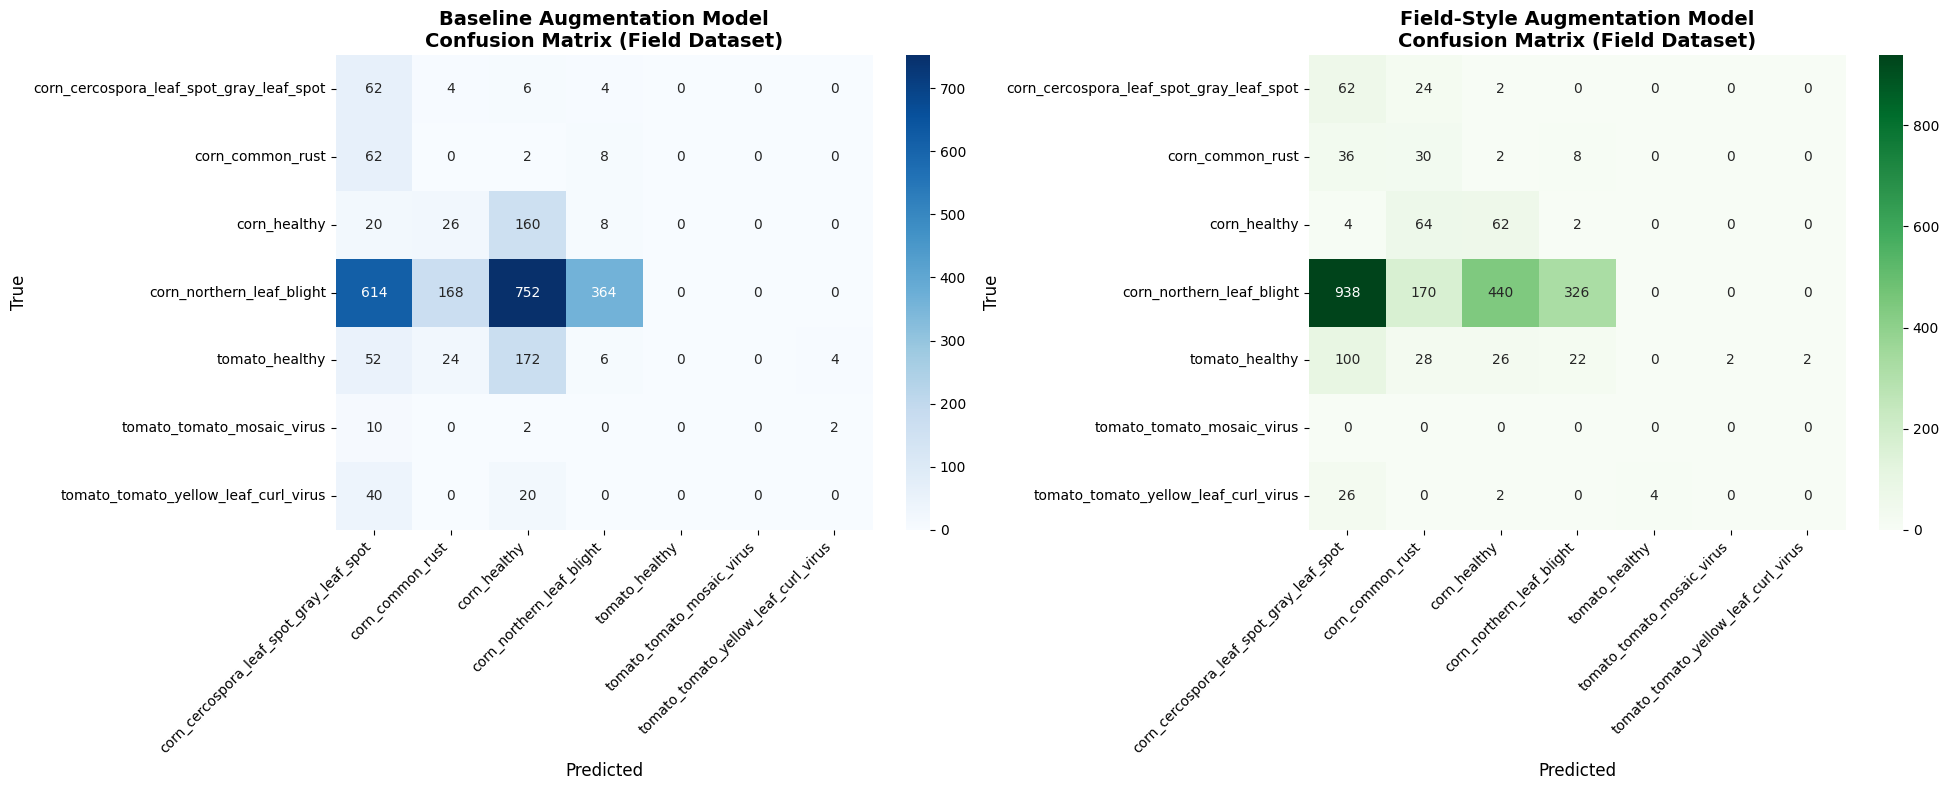

In [17]:
# Create confusion matrices (only for intersection classes)
intersection_class_ids = sorted([label_to_id[cls] for cls in intersection_classes])
intersection_class_names = [id_to_label[cid] for cid in intersection_class_ids]

# Filter confusion matrices to intersection classes only
cm_baseline = results_field_baseline['confusion_matrix']
cm_field_style = results_field_field_style['confusion_matrix']

# Extract only intersection classes
cm_baseline_filtered = cm_baseline[np.ix_(intersection_class_ids, intersection_class_ids)]
cm_field_style_filtered = cm_field_style[np.ix_(intersection_class_ids, intersection_class_ids)]

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Baseline confusion matrix
sns.heatmap(
    cm_baseline_filtered,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=intersection_class_names,
    yticklabels=intersection_class_names,
    ax=axes[0]
)
axes[0].set_title('Baseline Augmentation Model\nConfusion Matrix (Field Dataset)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('True', fontsize=12)
plt.setp(axes[0].get_xticklabels(), rotation=45, ha='right')
plt.setp(axes[0].get_yticklabels(), rotation=0)

# Field-style confusion matrix
sns.heatmap(
    cm_field_style_filtered,
    annot=True,
    fmt='d',
    cmap='Greens',
    xticklabels=intersection_class_names,
    yticklabels=intersection_class_names,
    ax=axes[1]
)
axes[1].set_title('Field-Style Augmentation Model\nConfusion Matrix (Field Dataset)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('True', fontsize=12)
plt.setp(axes[1].get_xticklabels(), rotation=45, ha='right')
plt.setp(axes[1].get_yticklabels(), rotation=0)

plt.tight_layout()
cm_save_path = EXPERIMENT_DIR / "confusion_matrices_field_dataset.png"
plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
print(f"\nSaved confusion matrices to: {cm_save_path}")
plt.show()


## Step 17: Summary Report


In [18]:
print("\n" + "="*70)
print("EXPERIMENT 3: SUMMARY REPORT")
print("="*70)

print("\n1. IN-DOMAIN EVALUATION (PlantVillage Test Set)")
print("-" * 70)
print(f"Baseline Augmentation Model:")
print(f"  Macro F1: {results_pv_baseline['f1_macro']:.4f}")
print(f"  Accuracy: {results_pv_baseline['accuracy']:.4f}")
print(f"\nField-Style Augmentation Model:")
print(f"  Macro F1: {results_pv_field_style['f1_macro']:.4f}")
print(f"  Accuracy: {results_pv_field_style['accuracy']:.4f}")
print(f"\nIn-Domain Performance Change:")
pv_f1_change = results_pv_field_style['f1_macro'] - results_pv_baseline['f1_macro']
pv_acc_change = results_pv_field_style['accuracy'] - results_pv_baseline['accuracy']
print(f"  Macro F1: {pv_f1_change:+.4f} ({pv_f1_change/results_pv_baseline['f1_macro']*100:+.2f}%)")
print(f"  Accuracy: {pv_acc_change:+.4f} ({pv_acc_change/results_pv_baseline['accuracy']*100:+.2f}%)")

print("\n2. OUT-OF-DOMAIN EVALUATION (Field Dataset - Intersection Classes Only)")
print("-" * 70)
print(f"Baseline Augmentation Model:")
print(f"  Macro F1: {results_field_baseline['f1_macro']:.4f}")
print(f"  Accuracy: {results_field_baseline['accuracy']:.4f}")
print(f"\nField-Style Augmentation Model:")
print(f"  Macro F1: {results_field_field_style['f1_macro']:.4f}")
print(f"  Accuracy: {results_field_field_style['accuracy']:.4f}")
print(f"\nOut-of-Domain Performance Improvement:")
field_f1_improvement = results_field_field_style['f1_macro'] - results_field_baseline['f1_macro']
field_acc_improvement = results_field_field_style['accuracy'] - results_field_baseline['accuracy']
print(f"  Macro F1: {field_f1_improvement:+.4f} ({field_f1_improvement/results_field_baseline['f1_macro']*100:+.1f}% relative improvement)")
print(f"  Accuracy: {field_acc_improvement:+.4f} ({field_acc_improvement/results_field_baseline['accuracy']*100:+.1f}% relative improvement)")

print("\n3. KEY FINDINGS")
print("-" * 70)
print(f"• Field-style augmentation {'improves' if field_f1_improvement > 0 else 'degrades'} generalization to field data")
print(f"• In-domain performance {'maintained' if abs(pv_f1_change) < 0.01 else 'changed'} ({pv_f1_change:+.4f})")
print(f"• Performance gap on field data: {results_field_baseline['f1_macro']:.4f} (baseline) vs {results_field_field_style['f1_macro']:.4f} (field-style)")

print("\n4. INTERPRETATION")
print("-" * 70)
if field_f1_improvement > 0:
    print("✓ Field-style augmentation improves generalization without exposure to real-world images")
    print("  This supports the hypothesis that domain-invariant features can be learned from clean data alone")
else:
    print("✗ Field-style augmentation does not improve generalization")
    print("  This suggests the need for robust pretraining, domain adaptation, or unlabeled real-world data")

if abs(pv_f1_change) > 0.01:
    print(f"\n⚠ Note: In-domain performance changed by {pv_f1_change:+.4f}")
    print("  This indicates a trade-off between in-domain and out-of-domain performance")
else:
    print("\n✓ In-domain performance maintained, indicating acceptable degradation")

print("\n" + "="*70)

# Save summary to file
summary_path = EXPERIMENT_DIR / "experiment_3_summary.txt"
with open(summary_path, 'w') as f:
    f.write("EXPERIMENT 3: AUGMENTATION COMPARISON SUMMARY\n")
    f.write("="*70 + "\n\n")
    f.write(f"In-Domain (PlantVillage Test):\n")
    f.write(f"  Baseline F1: {results_pv_baseline['f1_macro']:.4f}\n")
    f.write(f"  Field-Style F1: {results_pv_field_style['f1_macro']:.4f}\n")
    f.write(f"  Change: {pv_f1_change:+.4f}\n\n")
    f.write(f"Out-of-Domain (Field Dataset):\n")
    f.write(f"  Baseline F1: {results_field_baseline['f1_macro']:.4f}\n")
    f.write(f"  Field-Style F1: {results_field_field_style['f1_macro']:.4f}\n")
    f.write(f"  Improvement: {field_f1_improvement:+.4f} ({field_f1_improvement/results_field_baseline['f1_macro']*100:+.1f}%)\n")

print(f"\nSummary saved to: {summary_path}")



EXPERIMENT 3: SUMMARY REPORT

1. IN-DOMAIN EVALUATION (PlantVillage Test Set)
----------------------------------------------------------------------
Baseline Augmentation Model:
  Macro F1: 0.9871
  Accuracy: 0.9893

Field-Style Augmentation Model:
  Macro F1: 0.9571
  Accuracy: 0.9604

In-Domain Performance Change:
  Macro F1: -0.0300 (-3.04%)
  Accuracy: -0.0289 (-2.92%)

2. OUT-OF-DOMAIN EVALUATION (Field Dataset - Intersection Classes Only)
----------------------------------------------------------------------
Baseline Augmentation Model:
  Macro F1: 0.0212
  Accuracy: 0.1263

Field-Style Augmentation Model:
  Macro F1: 0.0189
  Accuracy: 0.1034

Out-of-Domain Performance Improvement:
  Macro F1: -0.0022 (-10.6% relative improvement)
  Accuracy: -0.0228 (-18.1% relative improvement)

3. KEY FINDINGS
----------------------------------------------------------------------
• Field-style augmentation degrades generalization to field data
• In-domain performance changed (-0.0300)
• Perf